In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
#detecting license plate on the vehicle
plateCascade = cv2.CascadeClassifier('lp.xml')

In [8]:
#detect the plate and return car + plate image
def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plateRect = plateCascade.detectMultiScale(plateImg,scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    return plateImg, plate_part

In [9]:
#normal function to display 
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()

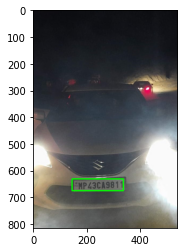

In [11]:
#test image is used for detecting plate
inputImg = cv2.imread('carplate.jpg')
inpImg, plate = plate_detect(inputImg)
display_img(inpImg)

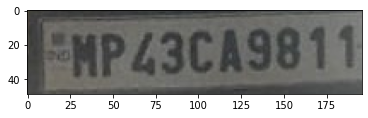

In [12]:
display_img(plate)

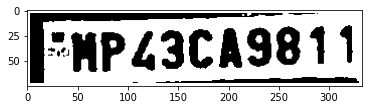

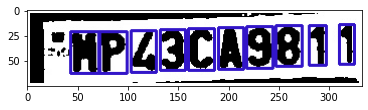

In [15]:
char = segment_characters(plate)

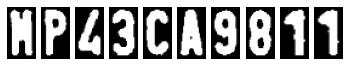

In [16]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [17]:
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score 
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28), 
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28),  
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [18]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [19]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])
model.compile(optimizer= "adam", loss='sparse_categorical_crossentropy', metrics=[custom_f1score])

In [20]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

In [21]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

C:\Users\mudri\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
864/864 [==============================] - 47s 32ms/step - loss: 3.5802 - custom_f1score: 0.0430 - val_loss: 3.4836 - val_custom_f1score: 0.0804
Epoch 2/80
864/864 [==============================] - 25s 29ms/step - loss: 3.7304 - custom_f1score: 0.0648 - val_loss: 3.1363 - val_custom_f1score: 0.1622
Epoch 3/80
864/864 [==============================] - 25s 29ms/step - loss: 3.1692 - custom_f1score: 0.1302 - val_loss: 2.8295 - val_custom_f1score: 0.1994
Epoch 4/80
864/864 [==============================] - 24s 28ms/step - loss: 2.9868 - custom_f1score: 0.1516 - val_loss: 2.7515 - val_custom_f1score: 0.2232
Epoch 5/80
864/864 [==============================] - 24s 28ms/step - loss: 2.8269 - custom_f1score: 0.1993 - val_loss: 2.7090 - val_custom_f1score: 0.2039
Epoch 6/80
864/864 [==============================] - 24s 28ms/step - loss: 2.7118 - custom_f1score: 0.2183 - val_loss: 2.7097 - val_custom_f1score: 0.2411
Epoch 7/80
864/864 [==============================] - 24s 28ms/s

In [22]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_] #
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

final_plate = show_results()
print(final_plate)

C:\Users\mudri\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


HP4JSA16YY


In [23]:
import requests
import xmltodict
import json

In [28]:
def get_vehicle_info(plate_number):
    r = requests.get("http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber=MP43CA9811&username=maddy".format(str(plate_number)))
    data = xmltodict.parse(r.content)
    jdata = json.dumps(data)
    df = json.loads(jdata)
    df1 = json.loads(df['Vehicle']['vehicleJson'])
    return df1


In [29]:
get_vehicle_info(final_plate)

{'Description': 'MARUTI SUZUKI BALENO DELTA PTR M1 BS6',
 'RegistrationYear': '2020',
 'CarMake': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'CarModel': {'CurrentTextValue': 'BALENO DELTA PTR M1 BS6'},
 'Variant': 'Delta 1.2 Petrol 1197.0',
 'EngineSize': {'CurrentTextValue': '1197.00'},
 'MakeDescription': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'ModelDescription': {'CurrentTextValue': 'BALENO DELTA PTR M1 BS6'},
 'NumberOfSeats': {'CurrentTextValue': '4'},
 'VechileIdentificationNumber': 'MA3EWB22SLJ684235',
 'EngineNumber': 'K12MN7573952',
 'FuelType': {'CurrentTextValue': 'PETROL'},
 'RegistrationDate': '02/11/2020',
 'Owner': 'MUKESH PORWAL',
 'Fitness': '',
 'Insurance': '',
 'PUCC': '',
 'VehicleType': 'L.M.V. (CAR)(LMV)',
 'Location': 'DTO,RATLAM DTO',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@TUFSVVRJIFNVWlVLSSBCQUxFTk8gREVMVEEgUFRSIE0xIEJTNg=='}

In [30]:
model.save('license_plate_character.pkl')

INFO:tensorflow:Assets written to: license_plate_character.pkl\assets


In [31]:
get_vehicle_info('WB06F5977')

{'Description': 'MARUTI SUZUKI BALENO DELTA PTR M1 BS6',
 'RegistrationYear': '2020',
 'CarMake': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'CarModel': {'CurrentTextValue': 'BALENO DELTA PTR M1 BS6'},
 'Variant': 'Delta 1.2 Petrol 1197.0',
 'EngineSize': {'CurrentTextValue': '1197.00'},
 'MakeDescription': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'ModelDescription': {'CurrentTextValue': 'BALENO DELTA PTR M1 BS6'},
 'NumberOfSeats': {'CurrentTextValue': '4'},
 'VechileIdentificationNumber': 'MA3EWB22SLJ684235',
 'EngineNumber': 'K12MN7573952',
 'FuelType': {'CurrentTextValue': 'PETROL'},
 'RegistrationDate': '02/11/2020',
 'Owner': 'MUKESH PORWAL',
 'Fitness': '',
 'Insurance': '',
 'PUCC': '',
 'VehicleType': 'L.M.V. (CAR)(LMV)',
 'Location': 'DTO,RATLAM DTO',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@TUFSVVRJIFNVWlVLSSBCQUxFTk8gREVMVEEgUFRSIE0xIEJTNg=='}